In [88]:
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import string
from datetime import date, timedelta

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime


from sklearn.linear_model import LinearRegression
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

In [89]:
pontos_de_corte = 0.0001
dias_tendencia_posterior = 3
dias_tendencia_anterior = -15

In [90]:
def remover_coluna(coluna: str, df) -> pd.DataFrame:
    return df.drop(coluna, axis=1)

def converter_coluna_em_numero(coluna: str, df) -> pd.Series:
    column = df[coluna] / 100
    return pd.to_numeric(column, errors='coerce')

def converter_coluna_em_data(coluna: str, df) -> pd.Series:
    return pd.to_datetime(df[coluna].str.slice(start=0, stop=4) \
            .str.cat(df[coluna].str.slice(start=4, stop=6), sep='-') \
            .str.cat(df[coluna].str.slice(start=6, stop=8), sep='-'))

def plotar_grafico(X, y, X_linear_regression=None, y_linear_regression=None, title=''):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(X, y)
    if X_linear_regression != None and y_linear_regression != None:
        ax.plot(X_linear_regression, y_linear_regression, label='Linear Pred')
    plt.xticks(rotation=90)
    plt.title(title)
    ax.legend()
    
def get_movimento_do_periodo(df, t_inicio, t_fim):
    result = df[(df['DATA'].dt.date < t_fim) & (df['DATA'].dt.date >= t_inicio)]
    # if len(result) == 0:
    #     data_fim = t_fim.strftime('%Y-%m-%d')
    #     data_inicio = t_inicio.strftime('%Y-%m-%d')
    #     return df[(df['DATA'] <= data_fim) & (df['DATA'] >= data_inicio)]
    return result

def add_days(t: int, data_atual: date):
    return data_atual + timedelta(days=t)

def estimativa_linear(movimento):

    X = np.array([range(1, len(movimento) + 1)]).T
    reg = LinearRegression().fit(X, movimento)
    
    predicao = reg.predict(X)

    return {'predicao' : predicao, 'coef': reg.coef_, 'score' : reg.score(X, movimento)}

def gerar_comparativo(df_selecionado, dt_atual : date, t = dias_tendencia_anterior, T = dias_tendencia_posterior):

    dt_inicio = add_days(t, dt_atual)
    dt_posterior = add_days(T, dt_atual)
    movimento = get_movimento_do_periodo(df_selecionado, dt_inicio, dt_atual)
    estimativa_anterior = estimativa_linear(movimento.PREMED.to_list())
    movimento = get_movimento_do_periodo(df_selecionado, dt_atual, dt_posterior)
    estimativa_posterior = estimativa_linear(movimento.PREMED.to_list())
    diff = estimativa_posterior['coef'] - estimativa_anterior['coef']
    return {'coef_anterior': estimativa_anterior['coef'], 'coef' : estimativa_posterior['coef'], 'coef_diff': diff, 'score' : estimativa_posterior['score']}

def plotar_periodo(df, dt_inicio, dt_fim, column_name):
    df[(df.DATA >= dt_inicio) & (df.DATA < dt_fim)].plot(x='DATA', y=column_name, title=f'{dt_inicio} a {dt_fim}', figsize=(19,5), rot=80, stacked=True)

    
def montar_analise_periodo(dt_atual, df, column_name='PREMED', column_support=None, estimativa=None, tendencia_anterior=None, title=None, dias_posteriores=dias_tendencia_posterior):
    t = dias_tendencia_anterior
    T = dias_posteriores
    dt_inicio = add_days(t, dt_atual)
    dt_posterior = add_days(T, dt_atual)

    movimento_do_periodo = get_movimento_do_periodo(df, dt_atual, dt_posterior)
    movimento_do_periodo.set_index(['DATA'], drop=False, inplace=True)
    movimento_do_periodo[column_name].plot()

    if column_support != None:
        movimento_do_periodo[column_support].plot(legend=True)

    if estimativa == None:
        estimativa = estimativa_linear(movimento_do_periodo[column_name].to_list())

    if tendencia_anterior != None:
        coef_anterior = tendencia_anterior['coef'][0]
        dias = len(movimento_do_periodo.DATA)
        primeiro_preco = estimativa['predicao'][0]
        ultimo_preco = coef_anterior * dias + primeiro_preco
        mov_anterior = pd.DataFrame({'tendencia_anterior' : [primeiro_preco, ultimo_preco]}, index=[movimento_do_periodo.DATA[0], movimento_do_periodo.DATA[-1]])
        mov_anterior.tendencia_anterior.plot(legend=True)

    mov_posterior_lin_reg = pd.DataFrame({'estimativa' : [estimativa['predicao'][0], estimativa['predicao'][-1]]}, index=[movimento_do_periodo.DATA[0], movimento_do_periodo.DATA[-1]])
    mov_posterior_lin_reg.estimativa.plot(figsize=(9, 4), legend=True, title=title)

In [91]:
df = pd.read_csv('COTAHIST.csv', sep=';', low_memory=False)
CODNEG = 'PETR3'
df_selecionado = df[df.CODNEG == CODNEG]

'Total de dados: ', len(df_selecionado)

('Total de dados: ', 1853)

In [92]:
df_selecionado.head()

,TIPREG,DATA,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
903,1,20150102,2.0,PETR3,10,PETROBRAS,ON,NaN,R$,958.0,967.0,900.0,916.0,900.0,900.0,905.0,17495.0,12710900.0,1.165181e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0
2401,1,20150105,2.0,PETR3,10,PETROBRAS,ON,NaN,R$,864.0,896.0,825.0,842.0,827.0,827.0,828.0,31288.0,24992200.0,2.100333e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0
3968,1,20150106,2.0,PETR3,10,PETROBRAS,ON,NaN,R$,828.0,853.0,778.0,808.0,806.0,805.0,806.0,33387.0,29572100.0,2.389582e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0
5695,1,20150107,2.0,PETR3,10,PETROBRAS,ON,NaN,R$,830.0,851.0,808.0,834.0,845.0,844.0,845.0,40079.0,33827600.0,2.825377e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0
7287,1,20150108,2.0,PETR3,10,PETROBRAS,ON,NaN,R$,860.0,926.0,852.0,898.0,902.0,901.0,902.0,59630.0,37177200.0,3.341734e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0


In [93]:
df_selecionado = remover_coluna('PRAZOT', df_selecionado)

In [94]:
df_selecionado['DATA_EM_TEXTO'] = df_selecionado['DATA']
df_selecionado['DATA'] = converter_coluna_em_data('DATA', df_selecionado)


In [95]:
df_selecionado['PREABE'] = converter_coluna_em_numero('PREABE', df_selecionado)
df_selecionado['PREMAX'] = converter_coluna_em_numero('PREMAX', df_selecionado)
df_selecionado['PREMIN'] = converter_coluna_em_numero('PREMIN', df_selecionado)
df_selecionado['PREMED'] = converter_coluna_em_numero('PREMED', df_selecionado)
df_selecionado['PREULT'] = converter_coluna_em_numero('PREULT', df_selecionado)
df_selecionado['PREOFC'] = converter_coluna_em_numero('PREOFC', df_selecionado)
df_selecionado['PREOFV'] = converter_coluna_em_numero('PREOFV', df_selecionado)

In [96]:
premed = df_selecionado.PREMED

In [97]:
premed = df_selecionado.PREMED
tam_max = len(premed)
media_movel = pd.Series(premed.rolling(window=abs(dias_tendencia_posterior), min_periods=1).mean())
df_selecionado['MEDIA_MOVEL'] = media_movel

In [98]:
print('data mínima:', df_selecionado['DATA'].min(), '| data máxima: ',df_selecionado['DATA'].max())

data mínima: 2015-01-02 00:00:00 | data máxima:  2022-06-29 00:00:00


In [99]:
df_selecionado.head()

,TIPREG,DATA,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,DATA_EM_TEXTO,MEDIA_MOVEL
903,1,2015-01-02,2.0,PETR3,10,PETROBRAS,ON,R$,9.58,9.67,9.00,9.16,9.00,9.00,9.05,17495.0,12710900.0,1.165181e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0,20150102,9.160000
2401,1,2015-01-05,2.0,PETR3,10,PETROBRAS,ON,R$,8.64,8.96,8.25,8.42,8.27,8.27,8.28,31288.0,24992200.0,2.100333e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0,20150105,8.790000
3968,1,2015-01-06,2.0,PETR3,10,PETROBRAS,ON,R$,8.28,8.53,7.78,8.08,8.06,8.05,8.06,33387.0,29572100.0,2.389582e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0,20150106,8.553333
5695,1,2015-01-07,2.0,PETR3,10,PETROBRAS,ON,R$,8.30,8.51,8.08,8.34,8.45,8.44,8.45,40079.0,33827600.0,2.825377e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0,20150107,8.280000
7287,1,2015-01-08,2.0,PETR3,10,PETROBRAS,ON,R$,8.60,9.26,8.52,8.98,9.02,9.01,9.02,59630.0,37177200.0,3.341734e+10,0.0,0.0,99991231.0,1.0,0.0,BRPETRACNOR9,183.0,20150108,8.466667


<AxesSubplot:>

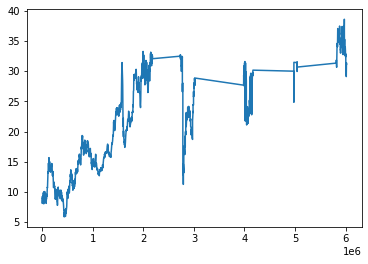

In [100]:
df_selecionado.PREMED.plot()

In [101]:
# df_selecionado = df_selecionado[(df_selecionado.DATA.dt.date >= add_days(dias_tendencia_anterior, date(2016, 4, 1))) & (df_selecionado.DATA.dt.date < date(2017, 3, 1))]

In [102]:
print('data mínima:', df_selecionado['DATA'].min(), '| data máxima: ',df_selecionado['DATA'].max())


data mínima: 2015-01-02 00:00:00 | data máxima:  2022-06-29 00:00:00


d:\Estudos\ML\venv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


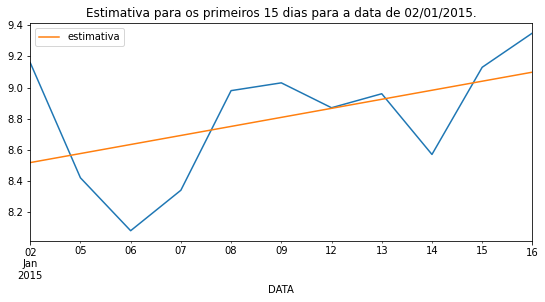

In [103]:
data_inicial =df_selecionado['DATA'].min()
montar_analise_periodo(dt_atual=data_inicial, dias_posteriores=abs(dias_tendencia_anterior), df=df_selecionado, column_name='PREMED', title=f"Estimativa para os primeiros {abs(dias_tendencia_anterior)} dias para a data de {data_inicial.strftime('%d/%m/%Y')}.")



In [104]:
dia_atual = date(2016, 4, 2)
dia_anterior = add_days(dias_tendencia_anterior, dia_atual)


<AxesSubplot:xlabel='DATA'>

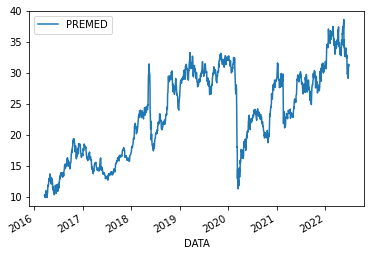

In [105]:
df_selecionado[df_selecionado.DATA.dt.date >= dia_anterior].plot(y='PREMED', x='DATA')

In [106]:


estimativa_anterior = get_movimento_do_periodo(df_selecionado, dia_anterior, dia_atual)
estimativa_anterior = estimativa_linear(estimativa_anterior.PREMED)


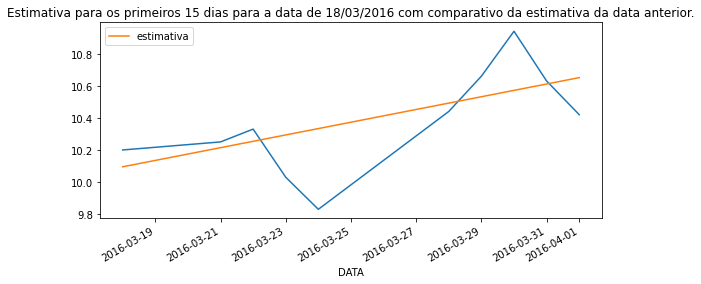

In [107]:

montar_analise_periodo(dt_atual=dia_anterior
, df=df_selecionado
, column_name='PREMED'
, title=f"Estimativa para os primeiros {abs(dias_tendencia_anterior)} dias para a data de {dia_anterior.strftime('%d/%m/%Y')} com comparativo da estimativa da data anterior."
, dias_posteriores=abs(dias_tendencia_anterior))



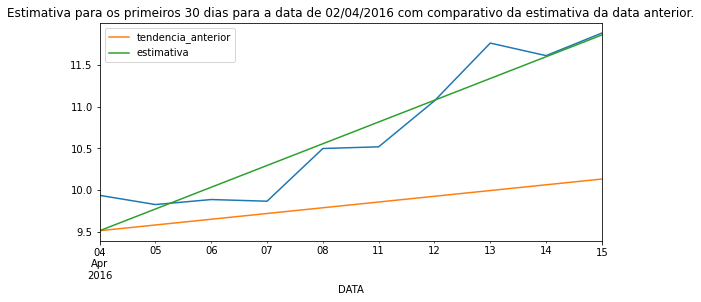

In [108]:

dt_atual = date(2016, 4, 2)
montar_analise_periodo(dt_atual=dt_atual
, df=df_selecionado
, column_name='PREMED'
, tendencia_anterior=estimativa_anterior
, title=f"Estimativa para os primeiros {30} dias para a data de {dt_atual.strftime('%d/%m/%Y')} com comparativo da estimativa da data anterior."
, dias_posteriores=15)



In [109]:
df_inicio = date(2016, 4, 1) # 2016-04-01	
dt_fim = add_days(30, df_inicio)
movimento = get_movimento_do_periodo(df_selecionado, df_inicio, dt_fim)
estimativa_anterior = estimativa_linear(movimento['PREMED'])


In [110]:
data_anterior = add_days(dias_tendencia_anterior, date(2015, 12, 5))

In [111]:
print('data mínima:', df_selecionado['DATA'].min(), '| data máxima: ',df_selecionado['DATA'].max())

data mínima: 2015-01-02 00:00:00 | data máxima:  2022-06-29 00:00:00


In [112]:
coefs = []
precos_tendencias = []
coefs_anteriores = []
coef_comparativo = []
precos_preditos = []
data_inicial_tendencia = []
dt_inicio = date(2015, 1, 2) # 2016-04-01	

for index, row in df_selecionado.iterrows():
    
    movimento_posterior = get_movimento_do_periodo(df_selecionado, row.DATA, add_days(dias_tendencia_posterior, row.DATA)).PREMED
    movimento_anterior = get_movimento_do_periodo(df_selecionado, add_days(dias_tendencia_anterior, row.DATA), row.DATA).PREMED
    estimativa = estimativa_linear(movimento_posterior)
    tendencia = estimativa_linear(movimento_posterior)
    if len(movimento_anterior) > 0:
        tendencia = estimativa_linear(movimento_anterior)
    else: 
        tendencia = estimativa_linear(movimento_posterior)
    coef = estimativa['coef'][0]
    coef_tendencia = tendencia['coef'][0]
    preco_atual = estimativa['predicao'][0]
    preco_tendencia = coef_tendencia * dias_tendencia_posterior + preco_atual
    precos_tendencias.append(preco_tendencia)
    precos_preditos.append(estimativa['predicao'][-1])
    
    coefs.append(coef)
    coefs_anteriores.append(coef_tendencia)
    coef_comparativo.append(coef - coef_tendencia)
    data_inicial_tendencia.append(add_days(dias_tendencia_anterior, row.DATA))

df_selecionado = df_selecionado[df_selecionado.DATA.dt.date >= dt_inicio]
df_selecionado['COEF'] = coefs
df_selecionado['COEF_ANTERIOR'] = coefs_anteriores
df_selecionado[f'TENDENCIA{abs(dias_tendencia_anterior)}'] = precos_tendencias
df_selecionado[f'ESTIMATIVA{dias_tendencia_posterior}'] = precos_preditos
df_selecionado['COMPARATIVO'] = coef_comparativo
df_selecionado['DATA_TENDENCIA_INCIAL'] = data_inicial_tendencia


d:\Estudos\ML\venv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
d:\Estudos\ML\venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
d:\Estudos\ML\venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
d:\Estudos\ML\venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
d:\Estudos\ML\venv\lib\site-packag

In [113]:
# df_selecionado = df_selecionado[(df_selecionado.DATA.dt.date >= date(2016, 4, 1)) & (df_selecionado.DATA.dt.date < date(2017, 3, 1))]

In [114]:
df_selecionado[df_selecionado.COMPARATIVO > 0.02].COMPARATIVO.max()

2.627090909090909

<AxesSubplot:>

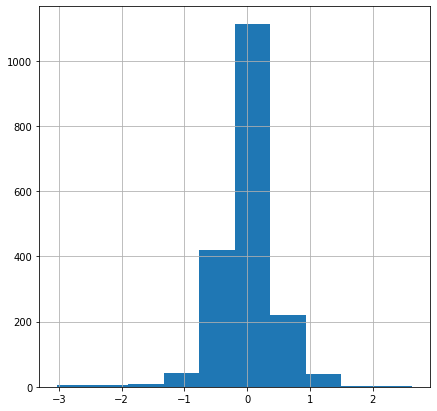

In [115]:
df_selecionado.COMPARATIVO.hist(figsize=(7,7))

In [116]:
df_selecionado['LABEL'] = [1 if valor >= pontos_de_corte else -1 if valor <= pontos_de_corte * (-1) else 0 for valor in df_selecionado['COMPARATIVO']]

In [117]:
df_selecionado.LABEL.shape

(1853,)

In [118]:
df_pronto = df_selecionado[[
    'DATA'
    , 'LABEL'
    , 'PREMED'
    , 'MEDIA_MOVEL'
    , 'COEF'
    , 'COEF_ANTERIOR'
    , f'TENDENCIA{abs(dias_tendencia_anterior)}'
    , f'ESTIMATIVA{abs(dias_tendencia_posterior)}'
    , 'COMPARATIVO'
]]

In [119]:
df_pronto.head()

,DATA,LABEL,PREMED,MEDIA_MOVEL,COEF,COEF_ANTERIOR,TENDENCIA15,ESTIMATIVA3,COMPARATIVO
903,2015-01-02,0,9.16,9.160000,0.000,0.00,9.160000,9.160000,0.000
2401,2015-01-05,-1,8.42,8.790000,-0.040,0.00,8.320000,8.240000,-0.040
3968,2015-01-06,1,8.08,8.553333,0.450,-0.74,5.796667,8.916667,1.190
5695,2015-01-07,1,8.34,8.280000,0.345,-0.54,6.818333,9.128333,0.885
7287,2015-01-08,1,8.98,8.466667,0.050,-0.28,8.140000,9.030000,0.330


In [120]:
df_pronto.to_excel('indices_per_date.xlsx', index=False)
df_pronto[df_pronto.LABEL == 0].shape, df_pronto[df_pronto.LABEL == 1].shape, df_pronto[df_pronto.LABEL == -1].shape, df_pronto.DATA.min(), df_pronto.DATA.max()

((2, 9),
 (912, 9),
 (939, 9),
 Timestamp('2015-01-02 00:00:00'),
 Timestamp('2022-06-29 00:00:00'))

In [121]:
df_pronto[df_pronto.LABEL == 0].shape

(2, 9)

<AxesSubplot:title={'center':'Tendência no prazo de 3 dias'}, xlabel='DATA'>

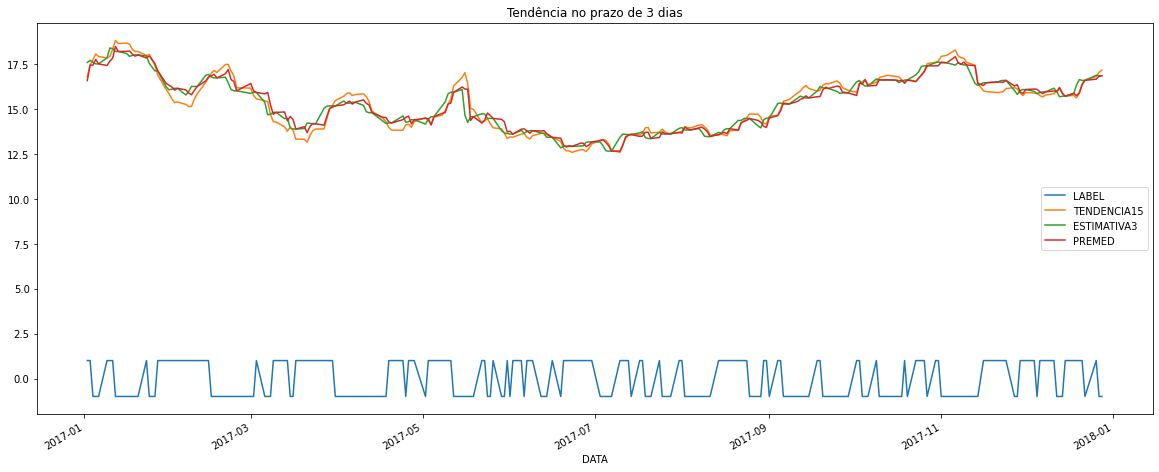

In [122]:
df_pronto[(df_pronto.DATA.dt.date < date(2018, 1, 1)) & (df_pronto.DATA.dt.date >= date(2017, 1, 1))].plot(kind='line', figsize=(20,8), x='DATA', y=['LABEL', f'TENDENCIA{abs(dias_tendencia_anterior)}', f'ESTIMATIVA{abs(dias_tendencia_posterior)}', 'PREMED'], title=f"Tendência no prazo de {dias_tendencia_posterior} dias")

<AxesSubplot:xlabel='DATA'>

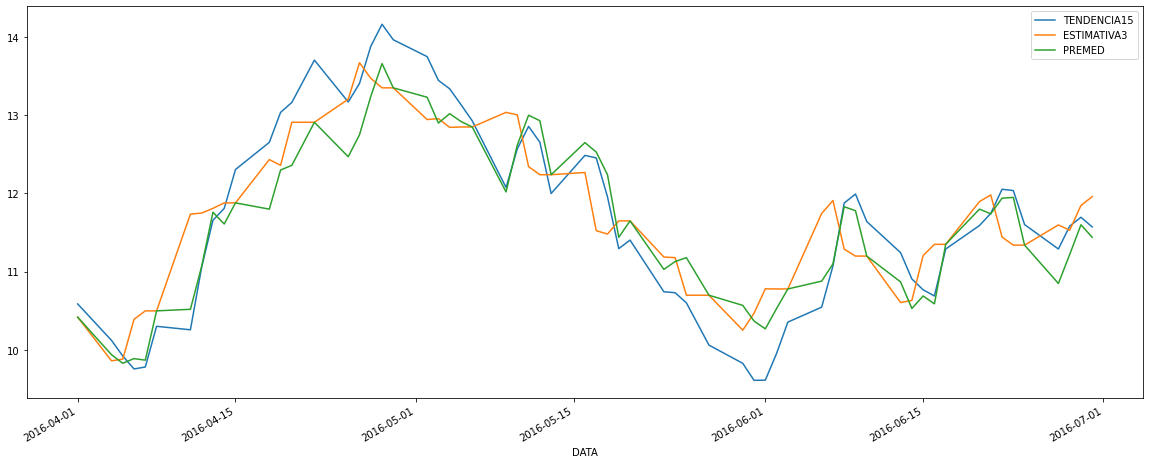

In [123]:
df_pronto[(df_pronto.DATA.dt.date >= date(2016, 4, 1)) & (df_pronto.DATA.dt.date < date(2016, 7, 1))].plot(kind='line', figsize=(20,8), x='DATA', y=[f'TENDENCIA{abs(dias_tendencia_anterior)}', f'ESTIMATIVA{abs(dias_tendencia_posterior)}', 'PREMED'])

<AxesSubplot:xlabel='DATA'>

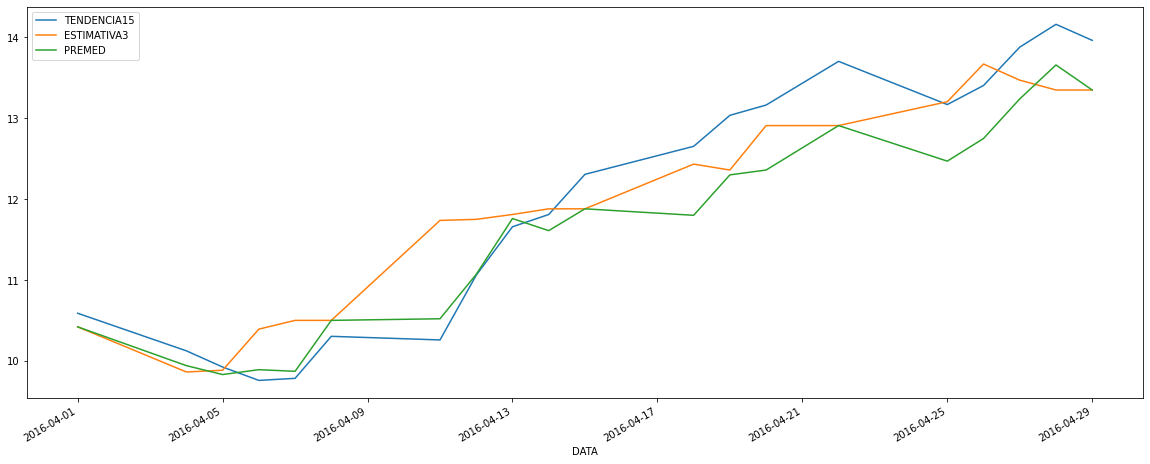

In [124]:
df_pronto[(df_pronto.DATA.dt.date >= date(2016, 4, 1)) & (df_pronto.DATA.dt.date < date(2016, 5, 1))].plot(kind='line', figsize=(20,8), x='DATA', y=[f'TENDENCIA{abs(dias_tendencia_anterior)}', f'ESTIMATIVA{abs(dias_tendencia_posterior)}', 'PREMED'])

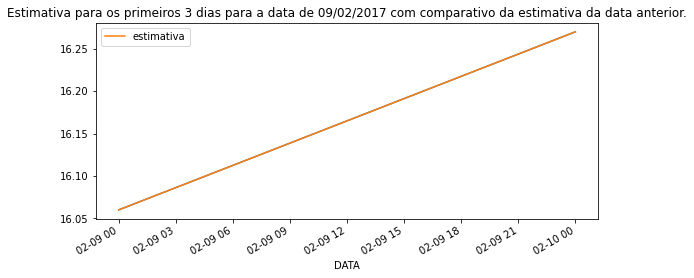

In [125]:
dt_atual = add_days(dias_tendencia_anterior, date(2017, 2, 24))
montar_analise_periodo(dt_atual=dt_atual
, df=df_selecionado
, column_name='PREMED'
, title=f"Estimativa para os primeiros {dias_tendencia_posterior} dias para a data de {dt_atual.strftime('%d/%m/%Y')} com comparativo da estimativa da data anterior.")
